# Partie III - Recherche du "meilleur" algorithme de classification

### Importation de l'Environnement et des Données

In [1]:
# Importation des bibliothèques nécessaires

import warnings  # Gestion des avertissements
import pandas as pd  # Traitement des données avec Pandas
import numpy as np  # Opérations numériques avec NumPy
import scipy.stats as stats  # Statistiques avec SciPy
from datetime import datetime  # Manipulation des dates

# Visualisation des données
import seaborn as sns  # Bibliothèque de visualisation avancée
from xplotter.insights import *  # Outils pour l'exploration des données
import matplotlib.pyplot as plt  # Tracé de graphiques
%matplotlib inline  # Affichage des graphiques dans le notebook
plt.rcParams["figure.figsize"] = 6, 4 # Définition de la taille par défaut des graphiques

sns.set_style("ticks")  # Style des graphiques
sns.color_palette("pink", as_cmap=True) # Palette de couleurs

# Modélisation
import sklearn # Bibliothèque de machine learning
from sklearn.model_selection import train_test_split # Séparation des données en ensembles d'entraînement et de test
from sklearn.preprocessing import StandardScaler # Standardisation des données

# Configuration de l'affichage des données
pd.set_option('display.float_format', '{:,.2f}'.format)

# Désactivation de l'affichage des avertissements
warnings.filterwarnings('ignore')

# Affichage des versions des bibliothèques utilisées
import sys
print("python version", sys.version)
print("pandas version :", pd.__version__)
print("numpy version :", np.__version__)
print("seaborn version :", sns.__version__)
print("sklearn version :", sklearn.__version__)

python version 3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]
pandas version : 2.0.3
numpy version : 1.24.3
seaborn version : 0.12.2
sklearn version : 1.3.2


## Importation des données

Nous importons les données traitées dans le notebook précédent.

In [2]:
# Chargement des données filtrées et analysées
X_test = pd.read_csv('./Data/X_test.csv') # Données de test
X_train = pd.read_csv('./Data/X_train.csv') # Données d'entraînement
y = pd.read_csv('./Data/y.csv') # Variable cible

# Suppression de la colonne 'sk_id_curr' des jeux de données d'entraînement et de test
X_train.drop(labels='sk_id_curr', axis=1, inplace=True)
X_test.drop(labels='sk_id_curr', axis=1, inplace=True)

# Affichage des dimensions des jeux de données
X_test.shape, X_train.shape, y.shape

((36374, 59), (44063, 59), (44063, 1))

In [3]:
# Séparation de l'ensemble X_train en deux sous-ensembles : X_Xtrain et X_valid
# Les sous-ensembles sont créés pour l'entraînement du modèle et la validation
X_Xtrain, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                       y, stratify=y, test_size=0.3, random_state=101)
# Affichage des dimensions des sous-ensembles créés
X_Xtrain.shape, X_valid.shape

((30844, 59), (13219, 59))

In [4]:
# Standardisation des données
scaler = StandardScaler()   # Initialisation de l'objet de standardisation
# Entraînement du scaler sur les données d'entraînement
scaler.fit(X_Xtrain)

# Application de la standardisation aux ensembles d'entraînement et de validation
X_train_sd = scaler.transform(X_Xtrain) # Données d'entraînement standardisées
X_valid_sd = scaler.transform(X_valid) # Données de validation standardisées

In [5]:
# Transformation des matrices standardisées en dataframes pour conserver les noms des variables
X_train_sd_df = pd.DataFrame(X_train_sd, columns=list(X_Xtrain)) # Données d'entraînement standardisées
X_valid_sd_df = pd.DataFrame(X_valid_sd, columns=list(X_Xtrain)) # Données de validation standardisées
y_train_df = pd.DataFrame(y_train)  # Variable cible pour l'entraînement
y_valid_df = pd.DataFrame(y_valid)  # Variable cible pour la validation

In [6]:
# Affichage des dimensions des dataframes après la transformation
X_train_sd_df.shape, X_valid_sd_df.shape, y_train_df.shape, y_valid_df.shape

((30844, 59), (13219, 59), (30844, 1), (13219, 1))

# La Cible à prédire : *Le client est-il en difficulté de paiement ?*

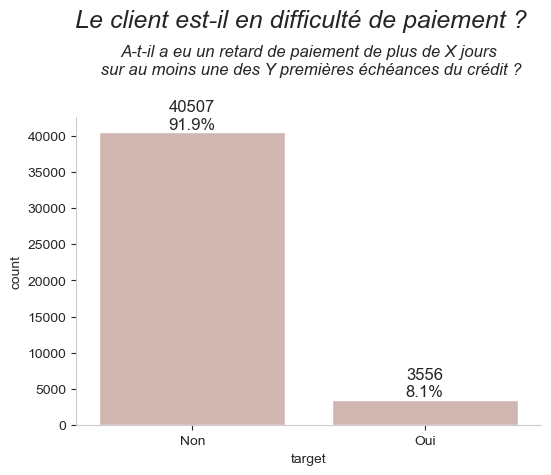

In [7]:
from xplotter.insights import *
# Définition des couleurs pour le graphique
colors = ['#d4b3ac']
# Mapping des valeurs de la variable cible
loan_map = {1 : "Oui",   # En difficulté de paiement
            0 : "Non"}   # Pas en difficulté de paiement

# Création de la figure et des axes pour le graphique
fig, ax = plt.subplots(figsize=(6, 4))

# Utilisation de la fonction plot_countplot pour créer un graphique à barres
plot_countplot(df=y,   # Données à utiliser
               col='target', # Variable à représenter
               label_names=loan_map, # Noms associés aux valeurs de la variable cible
               order=True, # Ordonner les barres
               palette=colors, ax=ax, orient='v', size_labels=12) # Paramètres du graphique

# Titres du graphique
plt.suptitle("Le client est-il en difficulté de paiement ?\n",
             y=1.15, fontsize=18, fontstyle='italic')
plt.title("A-t-il a eu un retard de paiement de plus de X jours\n sur au moins une des Y premières échéances du crédit ?\n\n",
           loc="center", fontsize=12, fontstyle='italic')
 # Affichage du graphique
plt.show()


In [8]:
# Affichage du ratio de déséquilibre entre les classes
print(f"imbalance_ratio = {24825 / 282686:.2%}")

imbalance_ratio = 8.78%


In [9]:
# Affichage des informations sur la variable cible dans l'ensemble d'entraînement
print("y_train_series - TARGET")

# Création d'un dataframe présentant le décompte et le ratio des valeurs de la variable cible
print(pd.DataFrame({
    "COUNT": y_train_df.value_counts(),  # Décompte des valeurs
    "RATIO": y_train_df.value_counts() / len(y_train_df) * 100})) # Ratio en pourcentage

y_train_series - TARGET
        COUNT  RATIO
target              
0       28355  91.93
1        2489   8.07


In [10]:
# Affichage des informations sur la variable cible dans l'ensemble de validation
print("y_valid_series - TARGET")

# Création d'un dataframe présentant le décompte et le ratio des valeurs de la variable cible
print(pd.DataFrame({
    "COUNT": y_valid_df.value_counts(),  # Décompte des valeurs
    "RATIO": y_valid_df.value_counts() / len(y_valid_df) * 100}))  # Ratio en pourcentage

y_valid_series - TARGET
        COUNT  RATIO
target              
0       12152  91.93
1        1067   8.07


## Accuracy (précision)

In [11]:
# Importation des modèles de machine learning et des métriques d'évaluation
from sklearn.ensemble import RandomForestClassifier  # Classifieur RandomForest
from sklearn.linear_model import LogisticRegression  # Régression logistique

from sklearn.metrics import accuracy_score    # Métrique : Taux de précision

In [12]:
# Création d'un modèle RandomForestClassifier avec les paramètres spécifiés
rf = RandomForestClassifier(n_estimators=100, random_state=101, max_depth=2, n_jobs=4)

# Entraînement du modèle sur les données d'entraînement standardisées
rf.fit(X_train_sd, y_train)

# Prédiction des probabilités pour les ensembles d'entraînement et de validation
y_train_rf = rf.predict_proba(X_train_sd)   # Probabilités prédites pour l'ensemble d'entraînement
y_valid_rf = rf.predict_proba(X_valid_sd)  # Probabilités prédites pour l'ensemble de validation

In [13]:
# Création d'un modèle de régression logistique (LogisticRegression) avec les paramètres spécifiés
logit = LogisticRegression(random_state=101,  max_iter=100)

# Entraînement du modèle sur les données d'entraînement standardisées
logit.fit(X_train_sd, y_train)

# Prédiction des probabilités pour les ensembles d'entraînement et de validation
y_train_logit = logit.predict_proba(X_train_sd)  # Probabilités prédites pour l'ensemble d'entraînement
y_valid_logit = logit.predict_proba(X_valid_sd)  # Probabilités prédites pour l'ensemble de validation

In [14]:
# Affichage du taux de précision pour le modèle Random Forest sur l'ensemble de validation
print(f"Accuracy Random Forest test : {accuracy_score(y_valid, rf.predict(X_valid_sd)):.2%}")

# Affichage du taux de précision pour le modèle de régression logistique sur l'ensemble de validation
print(f"Accuracy Logistic Regression test : {accuracy_score(y_valid, logit.predict(X_valid_sd)):.2%}")

Accuracy Random Forest test : 91.93%
Accuracy Logistic Regression test : 91.92%


In [15]:
# Fonction pour calculer le pourcentage de la classe minoritaire correctement classée
def return_minority_perc(y_true, y_pred):
    minority_total = np.sum(y_true) # Nombre total d'instances de la classe minoritaire
    if np.where(y_true == 1):
        minority_correct = np.sum(np.where(y_pred == 1, 1, 0)) # Nombre correctement classé de la classe minoritaire
    minority_perc = minority_correct / minority_total   # Calcul du pourcentage
    return minority_perc[0]

# Affichage du pourcentage de la classe minoritaire correctement classée pour le modèle Random Forest sur l'ensemble de validation
print(f"% de la minorité correctement classée, Random Forest test : {return_minority_perc(y_valid, rf.predict(X_valid_sd)):.2%}")

# Affichage du pourcentage de la classe minoritaire correctement classée pour le modèle de régression logistique sur l'ensemble de validation
print(f"% de la minorité correctement classée, Logistic Regression test : {return_minority_perc(y_valid, logit.predict(X_valid_sd)):.2%}")

% de la minorité correctement classée, Random Forest test : 0.00%
% de la minorité correctement classée, Logistic Regression test : 2.53%


## Rappel, précision et F1-score (Recall & Precision)

In [16]:
# Importation des métriques d'évaluation de classification
from sklearn.metrics import (
    precision_score, # Précision
    recall_score,  # Rappel
    f1_score,  # Score F1
    precision_recall_fscore_support,  # Précision, rappel, score F1 et support
)
# Importation des outils de visualisation Yellowbrick pour les modèles de classification
from yellowbrick.classifier import (
    ClassificationReport,   # Rapport de classification
    DiscriminationThreshold, # Seuil de discrimination
)

In [17]:
# Affichage de la précision pour le modèle Random Forest sur l'ensemble de validation
print(f"Precision Random Forest test : {precision_score(y_valid, rf.predict(X_valid_sd)):.2%}")

# Affichage de la précision pour le modèle de régression logistique sur l'ensemble de validation
print(f"Precision Logistic Regression test : {precision_score(y_valid, logit.predict(X_valid_sd)):.2%}")

Precision Random Forest test : 0.00%
Precision Logistic Regression test : 48.15%


In [18]:
# Affichage du rappel pour le modèle Random Forest sur l'ensemble de validation
print(f"Recall Random Forest test : {recall_score(y_valid, rf.predict(X_valid_sd), pos_label=1):.2%}")

# Affichage du rappel pour le modèle de régression logistique sur l'ensemble de validation
print(f"Recall Logistic Regression test : {recall_score(y_valid, logit.predict(X_valid_sd), pos_label=1):.2%}")

Recall Random Forest test : 0.00%
Recall Logistic Regression test : 1.22%


In [19]:
# Affichage du score F1 pour le modèle Random Forest sur l'ensemble de validation
print(f"F1 score Random Forest test : {f1_score(y_valid, rf.predict(X_valid_sd), pos_label=1):.2%}")

# Affichage du score F1 pour le modèle de régression logistique sur l'ensemble de validation
print(f"F1 score Logistic Regression test : {f1_score(y_valid, logit.predict(X_valid_sd), pos_label=1):.2%}")

F1 score Random Forest test : 0.00%
F1 score Logistic Regression test : 2.38%


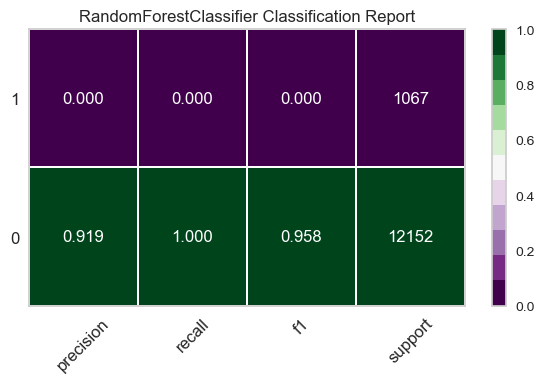

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [20]:
# Création de la figure et des axes pour le rapport de classification
fig, ax = plt.subplots(figsize=(6, 4))
# Initialisation de l'outil de visualisation ClassificationReport avec le modèle RandomForest
visualizer = ClassificationReport(rf, support=True, cmap='PRGn')
# Entraînement de l'outil de visualisation sur les données d'entraînement
visualizer.fit(X_train_sd, y_train)  
# Évaluation du modèle sur les données de validation
visualizer.score(X_valid_sd, y_valid)  
# Affichage du rapport de classification
visualizer.show()                       

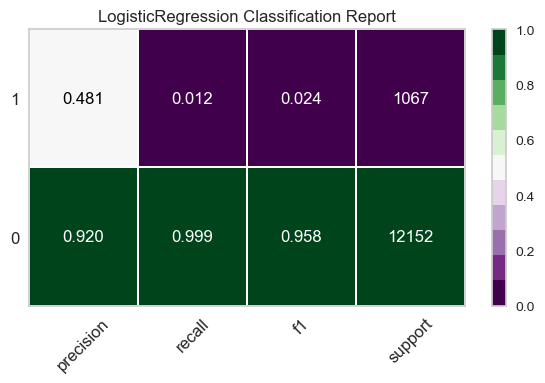

<Axes: title={'center': 'LogisticRegression Classification Report'}>

In [21]:
# Création de la figure et des axes pour le rapport de classification
fig, ax = plt.subplots(figsize=(6, 4))
# Initialisation de l'outil de visualisation ClassificationReport avec le modèle de régression logistique
visualizer = ClassificationReport(logit, support=True, cmap='PRGn')
# Entraînement de l'outil de visualisation sur les données d'entraînement
visualizer.fit(X_train_sd, y_train) 
# Évaluation du modèle sur les données de validation
visualizer.score(X_valid_sd, y_valid)
# Affichage du rapport de classification
visualizer.show()                       

## Precision and Recall, vs probability threshold

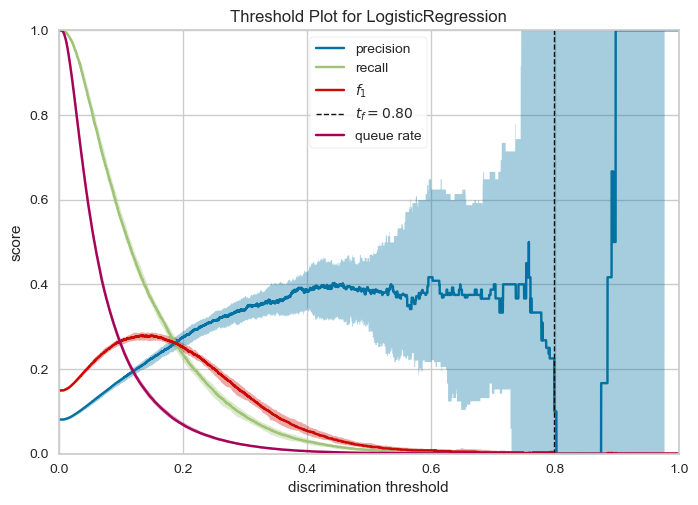

<Axes: title={'center': 'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [22]:
# Initialisation de l'outil de visualisation DiscriminationThreshold avec le modèle de régression logistique
visualizer = DiscriminationThreshold(logit,
                                     n_trials=50,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=101,
                                     is_fitted='auto')
# Entraînement de l'outil de visualisation sur les données d'entraînement
visualizer.fit(X_train_sd, y_train) 
# Évaluation du modèle sur les données de validation
visualizer.score(X_valid_sd, y_valid)  
# Affichage du graphique de seuil de discrimination
visualizer.show()  

##  Balanced Accuracy Weighted

In [23]:
# Importation de la métrique d'accuracy équilibrée
from sklearn.metrics import balanced_accuracy_score

# Affichage de l'accuracy équilibrée pour le modèle Random Forest sur l'ensemble de validation
print(f"Balanced accuracy Random Forest test : {balanced_accuracy_score(y_valid, rf.predict(X_valid_sd)):.2%}")

# Affichage de l'accuracy équilibrée pour le modèle de régression logistique sur l'ensemble de validation
print(f"Balanced accuracy Logistic Regression test : {balanced_accuracy_score(y_valid, logit.predict(X_valid_sd)):.2%}")

Balanced accuracy Random Forest test : 50.00%
Balanced accuracy Logistic Regression test : 50.55%


In [24]:
# Affichage du rappel pour le modèle Random Forest sur l'ensemble de validation, pour chaque classe (0 et 1)
print('Recall Random Forest test, class 0 and 1:', recall_score(y_valid, rf.predict(X_valid_sd), labels=[0,1], average=None))

# Affichage du rappel pour le modèle de régression logistique sur l'ensemble de validation, pour chaque classe (0 et 1)
print('Recall Logistic Regression test, class 0 and 1:',  recall_score(y_valid, logit.predict(X_valid_sd), labels=[0,1], average=None))

Recall Random Forest test, class 0 and 1: [1. 0.]
Recall Logistic Regression test, class 0 and 1: [0.99884793 0.01218369]


## ROC-AUC

In [25]:
# Importation des métriques d'AUC-ROC
from sklearn.metrics import roc_auc_score, roc_curve
# Importation de l'outil de visualisation ROCAUC de Yellowbrick pour les modèles de classification
from yellowbrick.classifier import ROCAUC

### Random Forest Classifier

In [26]:
# Création d'un modèle RandomForestClassifier avec les paramètres spécifiés
rf_model = RandomForestClassifier(n_estimators=100, random_state=101, max_depth=2, n_jobs=4)

# Entraînement du modèle sur les données d'entraînement standardisées
rf_model.fit(X_train_sd, y_train)

# Prédiction des probabilités pour les ensembles d'entraînement et de validation
# Conservation uniquement des probabilités associées à la classe positive
y_train_rf = rf_model.predict_proba(X_train_sd)[:,1]
y_valid_rf = rf_model.predict_proba(X_valid_sd)[:,1]

In [27]:
# Affichage du score ROC-AUC pour le modèle Random Forest sur l'ensemble d'entraînement
print(f"ROC-AUC Random Forest Train : {roc_auc_score(y_train, y_train_rf):.2%}")

# Affichage du score ROC-AUC pour le modèle Random Forest sur l'ensemble de validation
print(f"ROC-AUC Random Forest test : {roc_auc_score(y_valid, y_valid_rf):.2%}")

ROC-AUC Random Forest Train : 71.29%
ROC-AUC Random Forest test : 69.95%


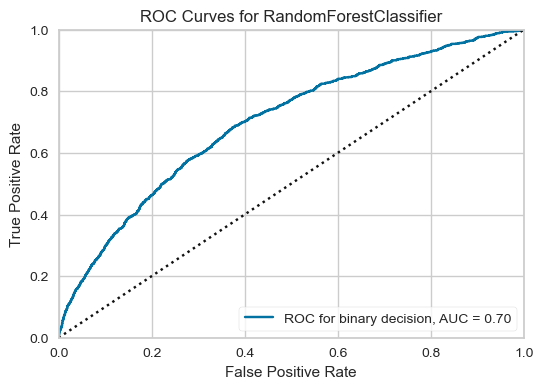

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [28]:
# Création de la figure et des axes pour la visualisation ROCAUC
fig, ax = plt.subplots(figsize=(6, 4))
# Initialisation de l'outil de visualisation ROCAUC avec le modèle Random Forest
visualizer = ROCAUC(rf_model, binary=True, 
                    random_state=101)
# Entraînement de l'outil de visualisation sur les données d'entraînement
visualizer.fit(X_train_sd, y_train) 
# Évaluation du modèle sur les données de validation
visualizer.score(X_valid_sd, y_valid)
# Affichage de la courbe ROC-AUC
visualizer.show()                       

In [29]:
# Calcul des courbes ROC (Receiver Operating Characteristic)
TFP, TVP, thresholds = roc_curve(y_valid, y_valid_rf)

In [30]:
# Calcul de la moyenne géométrique (g-mean) pour chaque seuil
gmeans = np.sqrt(TVP * (1-TFP))

In [31]:
# Recherche de l'indice correspondant au plus grand g-mean
ix = np.argmax(gmeans)
print(f"Best-Threshold={thresholds[ix]:.2%}, G-Mean={gmeans[ix]:.2%}")

Best-Threshold=8.14%, G-Mean=65.42%


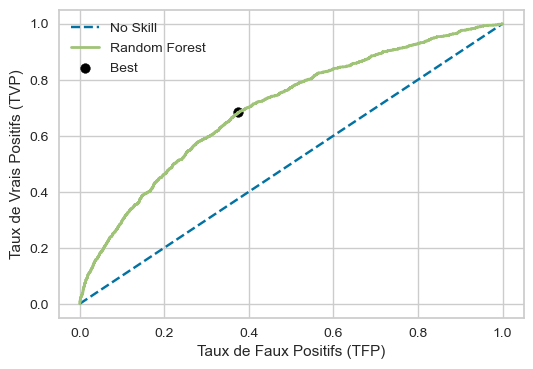

In [32]:
# Tracé de la courbe ROC pour le modèle

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(6, 4))

# Tracé de la ligne en pointillés représentant le modèle aléatoire (No Skill)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

# Tracé de la courbe ROC pour le modèle Random Forest
plt.plot(TFP, TVP, linestyle='-', linewidth=2, label='Random Forest')

# Marquage du meilleur point sur la courbe ROC
plt.scatter(TFP[ix], TVP[ix], marker='o', color='black', label='Best')

# Étiquetage des axes
plt.xlabel('Taux de Faux Positifs (TFP)')
plt.ylabel('Taux de Vrais Positifs (TVP)')
plt.legend()
# Affichage de la légende
plt.show()

### Logistic Regression

In [33]:
# Création d'un modèle de régression logistique avec les paramètres spécifiés
logit_model = LogisticRegression(random_state=101,  max_iter=100)

# Entraînement du modèle sur les données d'entraînement standardisées
logit_model.fit(X_train_sd, y_train)

# Prédiction des probabilités pour les ensembles d'entraînement et de validation
# Conservation uniquement des probabilités associées à la classe positive
y_train_logit = logit_model.predict_proba(X_train_sd)[:,1]
y_valid_logit = logit_model.predict_proba(X_valid_sd)[:,1]

In [34]:
# Affichage du score ROC-AUC pour le modèle de régression logistique sur l'ensemble d'entraînement
print(f"ROC-AUC Logistic Regression Train : {roc_auc_score(y_train, y_train_logit):.2%}")

# Affichage du score ROC-AUC pour le modèle de régression logistique sur l'ensemble de validation
print(f"ROC-AUC Logistic Regression test : {roc_auc_score(y_valid, y_valid_logit):.2%}")

ROC-AUC Logistic Regression Train : 73.62%
ROC-AUC Logistic Regression test : 72.57%


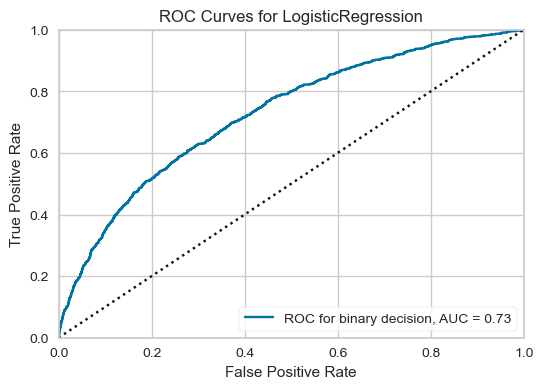

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [35]:
# Création de la figure et des axes pour la visualisation ROCAUC
fig, ax = plt.subplots(figsize=(6, 4))

# Initialisation de l'outil de visualisation ROCAUC avec le modèle de régression logistique
visualizer = ROCAUC(logit_model, binary=True, random_state=101)

# Entraînement de l'outil de visualisation sur les données d'entraînement
visualizer.fit(X_train_sd, y_train)
# Évaluation du modèle sur les données de validation
visualizer.score(X_valid_sd, y_valid)  
# Affichage de la courbe ROC-AUC
visualizer.show()                       

Best-Threshold=8.42%, G-Mean=66.33%


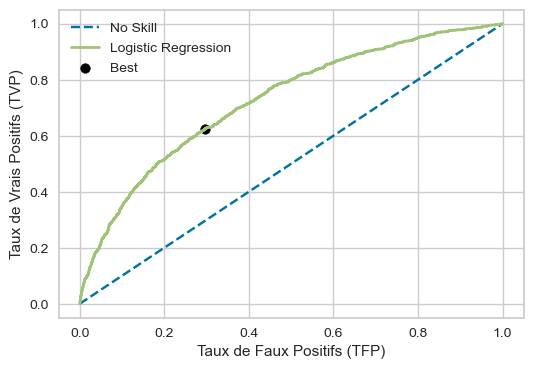

In [36]:
# Calcul des courbes ROC (Receiver Operating Characteristic) pour le modèle de régression logistique
TFP, TVP, thresholds = roc_curve(y_valid, y_valid_logit)

# Calcul de la moyenne géométrique (g-mean) pour chaque seuil
gmeans = np.sqrt(TVP * (1-TFP))

# Recherche de l'indice correspondant au plus grand g-mean
ix = np.argmax(gmeans)
print(f"Best-Threshold={thresholds[ix]:.2%}, G-Mean={gmeans[ix]:.2%}")

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(6, 4))
# Tracé de la ligne en pointillés représentant le modèle aléatoire (No Skill)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

# Tracé de la courbe ROC pour le modèle de régression logistique
plt.plot(TFP, TVP, linestyle='-', linewidth=2, label='Logistic Regression')

# Marquage du meilleur point sur la courbe ROC
plt.scatter(TFP[ix], TVP[ix], marker='o', color='black', label='Best')

# Étiquetage des axes
plt.xlabel('Taux de Faux Positifs (TFP)')
plt.ylabel('Taux de Vrais Positifs (TVP)')

# Affichage de la légende
plt.legend()

# Affichage du graphique
plt.show()

## Precision-Recall (PR) Curve et AUC Precision Recall

In [37]:
# Importation de l'outil de visualisation Precision-Recall Curve de Yellowbrick pour les modèles de classification
from yellowbrick.classifier import PrecisionRecallCurve
# Importation des métriques de précision et rappel
from sklearn.metrics import precision_recall_curve, auc

### Précision-Rappel : Random Forest Classifier

In [38]:
# Création d'un modèle RandomForestClassifier avec les paramètres spécifiés
rf_model = RandomForestClassifier(n_estimators=100, random_state=101, max_depth=2, n_jobs=4)

# Entraînement du modèle sur les données d'entraînement standardisées
rf_model.fit(X_train_sd, y_train)

# Prédiction des probabilités pour les ensembles d'entraînement et de validation
# Conservation uniquement des probabilités associées à la classe positive
y_train_rf = rf_model.predict_proba(X_train_sd)[:,1]
y_valid_rf = rf_model.predict_proba(X_valid_sd)[:,1]

In [39]:
# Random Forests

# Calcul de la précision, du rappel et des seuils pour la courbe Precision-Recall
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_valid, y_valid_rf)

# Calcul de l'aire sous la courbe Precision-Recall en utilisant les valeurs précédemment obtenues
auc_rf = auc(recall_rf, precision_rf)
print(f"Area under PR Curve Random Forests : {auc_rf:.2%}")

Area under PR Curve Random Forests : 18.59%


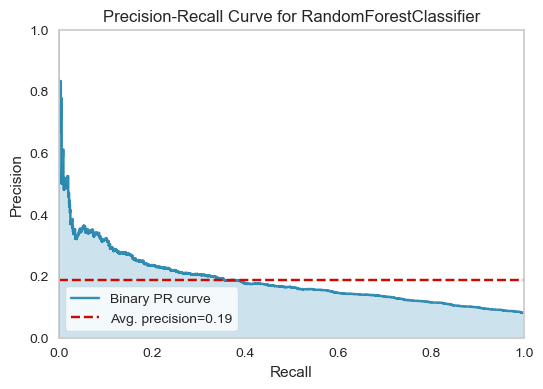

<Axes: title={'center': 'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [40]:
# Création de la figure et des axes pour la visualisation de la courbe Précision-Rappel
fig, ax = plt.subplots(figsize=(6, 4))
# Initialisation de l'outil de visualisation PrecisionRecallCurve avec le modèle Random Forest
visualizer = PrecisionRecallCurve(rf_model, random_state=101)
# Entraînement de l'outil de visualisation sur les données d'entraînement
visualizer.fit(X_train_sd, y_train) 
# Évaluation du modèle sur les données de validation
visualizer.score(X_valid_sd, y_valid)    
# Affichage de la courbe Précision-Rappel
visualizer.show()  

Randon Forest : 
Best-Threshold=9.24%, F-Score==25.18%


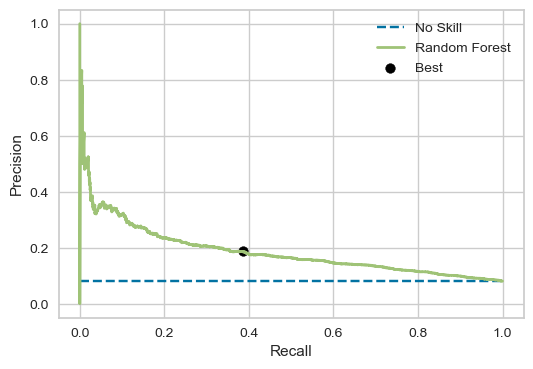

In [41]:
# Conversion en score F
fscore_rf = ((2 * precision_rf * recall_rf) / (precision_rf + recall_rf))

# Recherche de l'indice correspondant au plus grand score F
ix = np.argmax(fscore_rf[~np.isnan(fscore_rf)])
print(f"Randon Forest : \nBest-Threshold={thresholds_rf[ix]:.2%}, F-Score=={fscore_rf[ix]:.2%}")

# Tracé de la courbe ROC pour le modèle de régression logistique

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(6, 4))
# Calcul du seuil pour la courbe No Skill
no_skill = y_valid.query('target > 0').shape[0] / len(y_valid)
# Tracé de la ligne en pointillés représentant le modèle No Skill
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# Tracé de la courbe Precision-Recall pour le modèle Random Forest
plt.plot(recall_rf, precision_rf, linestyle='-', linewidth=2, label='Random Forest')
# Marquage du meilleur point sur la courbe Precision-Recall
plt.scatter(recall_rf[ix], precision_rf[ix], marker='o', color='black', label='Best')

# Étiquetage des axes
plt.xlabel('Recall')
plt.ylabel('Precision')
# Affichage de la légende
plt.legend()
# Affichage du graphique
plt.show()

### Précision-Rappel : Logistic Regression

In [42]:
# Création d'un modèle de régression logistique avec les paramètres spécifiés
logit_model = LogisticRegression(random_state=101,  max_iter=100)
# Entraînement du modèle sur les données d'entraînement standardisées
logit_model.fit(X_train_sd, y_train)
# Prédiction des probabilités pour les ensembles d'entraînement et de validation
# Conservation uniquement des probabilités associées à la classe positive
y_train_lr = logit_model.predict_proba(X_train_sd)[:,1]
y_valid_lr = logit_model.predict_proba(X_valid_sd)[:,1]

In [43]:
# Régression Logistique

# Calcul de la précision, du rappel et des seuils pour la courbe Precision-Recall
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_valid, y_valid_lr)

# Calcul de l'aire sous la courbe Precision-Recall en utilisant les valeurs précédemment obtenues
auc_lr = auc(recall_lr, precision_lr)
print(f"Area under PR Curve Logistic Regression : {auc_lr:.2%}")

Area under PR Curve Logistic Regression : 21.19%


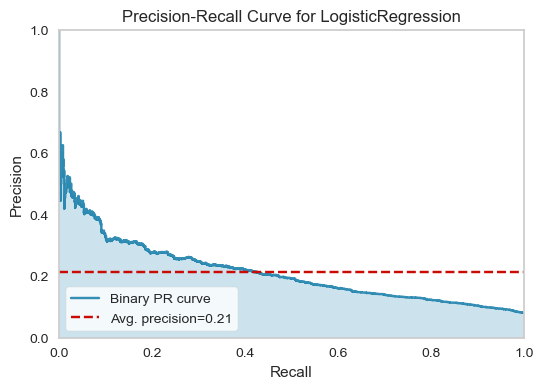

<Axes: title={'center': 'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [44]:
# Création de la figure et des axes pour la visualisation de la courbe Précision-Rappel
fig, ax = plt.subplots(figsize=(6, 4))
# Initialisation de l'outil de visualisation PrecisionRecallCurve avec le modèle de régression logistique
visualizer = PrecisionRecallCurve(logit_model, random_state=101)
# Entraînement de l'outil de visualisation sur les données d'entraînement
visualizer.fit(X_train_sd, y_train)   
# Évaluation du modèle sur les données de validation
visualizer.score(X_valid_sd, y_valid)   
# Affichage de la courbe Précision-Rappel
visualizer.show()  

Logistic Regression : 
Best-Threshold=14.06%, F-Score==28.66%


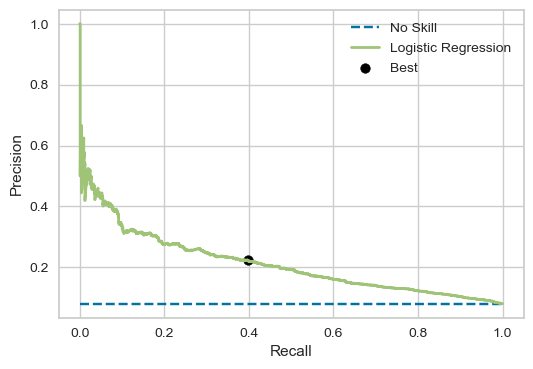

In [45]:
# Conversion en score F
fscore_lr = ((2 * precision_lr * recall_lr) / (precision_lr + recall_lr))

# Recherche de l'indice correspondant au plus grand score F
ix = np.argmax(fscore_lr[~np.isnan(fscore_lr)])
print(f"Logistic Regression : \nBest-Threshold={thresholds_lr[ix]:.2%}, F-Score=={fscore_lr[ix]:.2%}")

# Tracé de la courbe ROC pour le modèle de régression logistique

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(6, 4))
# Calcul du seuil pour la courbe No Skill
no_skill = y_valid.query('target > 0').shape[0] / len(y_valid)
# Tracé de la ligne en pointillés représentant le modèle No Skill
plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='No Skill')
# Tracé de la courbe Precision-Recall pour le modèle de régression logistique
plt.plot(recall_lr, precision_lr, linestyle='-', linewidth=2, label='Logistic Regression')
# Marquage du meilleur point sur la courbe Precision-Recall
plt.scatter(recall_lr[ix], precision_lr[ix], marker='o', color='black', label='Best')

# Étiquetage des axes
plt.xlabel('Recall')
plt.ylabel('Precision')

# Affichage de la légende
plt.legend()
# Affichage du graphique
plt.show()

   - Rappel élevé + Précision élevée : la classe minoritaire est parfaitement gérée par le modèle et ce dernier est capable de bien différencier les différentes classes.
   - Faible rappel + haute précision : le modèle ne peut pas bien détecter la classe, mais il est très fiable lorsqu'il le fait.
   - Rappel élevé + Précision faible : la classe est bien détectée mais le modèle classe également mal les points de la majorité
   - Faible rappel + Faible précision : la classe est mal gérée par le modèle

## Choix du modèle de prédiction avec Prise en compte du déséquilibre des classes

### Modèles de prédiction de référence

In [46]:
# Importation des bibliothèques nécessaires
import time

# Importation des métriques et outils d'évaluation
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

# Importation du classifieur de base pour la comparaison
from sklearn.dummy import DummyClassifier

# Importation des outils pour la validation croisée
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Importation des outils pour la construction de pipelines
from sklearn.pipeline import Pipeline

# Importation des algorithmes de classification
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [47]:
# Définition de la fonction pour calculer la mesure F2
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

In [48]:
# Évaluation d'un modèle
def evaluate_model(X, y, model):
    # Définition de la procédure d'évaluation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=101)
    # Définition de la métrique d'évaluation du modèle
    metric = make_scorer(f2_measure)
    # Évaluation du modèle
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-2)
    return scores

DummyClassifier effectue des prédictions qui ignorent les entités d'entrée.

Ce classificateur sert de référence simple à comparer avec d'autres classificateurs plus complexes.

In [49]:
# Définition du modèle de référence
model = DummyClassifier(strategy='constant', constant=1)

# Évaluation du modèle
scores = evaluate_model(X_train_sd, y_train, model)

# Résumé des performances
print("Calcul du F2 pour le Modèle de Référence avec constante = 1 et sans variable explicative :")
print(f"Score F2 : moyenne = {np.mean(scores):.2%}, écart_type = {np.std(scores):.2%}")

Calcul du F2 pour le Modèle de Référence avec constante = 1 et sans variable explicative :
Score F2 : moyenne = 30.50%, écart_type = 0.03%


In [50]:
# Définition des modèles à tester
def get_models():
    models, names = list(), list()
    # Régression Logistique
    models.append(LogisticRegression())
    names.append('Logistic_Regression')
    # Support Vector Machine linéaire
    models.append(LinearSVC())
    names.append('Linear_SVC')
    # Arbre de Décision
    models.append(DecisionTreeClassifier())
    names.append('Decision_Tree_Classifier')
    # Random Forest
    models.append(RandomForestClassifier())
    names.append('Random_Forest_Classifier')
    # XGBoost
    models.append(XGBClassifier())
    names.append('XGB_Classifier') 
    # LightGBM
    models.append(LGBMClassifier())
    names.append('LGBM_Classifier')
    return models, names

In [51]:
# Définition des modèles
models, names = get_models()
results = list()

# Évaluation de chaque modèle
for i in range(len(models)):
    temps = time.time()
    
   # Envelopper le modèle dans un pipeline
    pipeline = Pipeline(steps=[('m', models[i])])
    scores = evaluate_model(X_train_sd, y_train, pipeline)
    results.append(scores)
    duration=time.time()-temps
    
    # Résumé et stockage des résultats
    print(f"Score F2 du modèle {names[i]} : moyenne = {np.mean(scores):.2%}, écart_type = {np.std(scores):.2%}")
    print(f"Temps de Calcul pour {names[i]} : {duration:>15.2f} secondes")
    print(end='\n\n')

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

Score F2 du modèle Logistic_Regression : moyenne = 1.11%, écart_type = 0.73%
Temps de Calcul pour Logistic_Regression :            6.88 secondes




/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to s

Score F2 du modèle Linear_SVC : moyenne = 0.03%, écart_type = 0.13%
Temps de Calcul pour Linear_SVC :          163.73 secondes


Score F2 du modèle Decision_Tree_Classifier : moyenne = 14.75%, écart_type = 2.15%
Temps de Calcul pour Decision_Tree_Classifier :           16.51 secondes




/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

Score F2 du modèle Random_Forest_Classifier : moyenne = 0.00%, écart_type = 0.00%
Temps de Calcul pour Random_Forest_Classifier :          123.89 secondes


Score F2 du modèle XGB_Classifier : moyenne = 4.31%, écart_type = 1.17%
Temps de Calcul pour XGB_Classifier :           16.67 secondes




/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

Score F2 du modèle LGBM_Classifier : moyenne = 2.22%, écart_type = 0.99%
Temps de Calcul pour LGBM_Classifier :           17.36 secondes




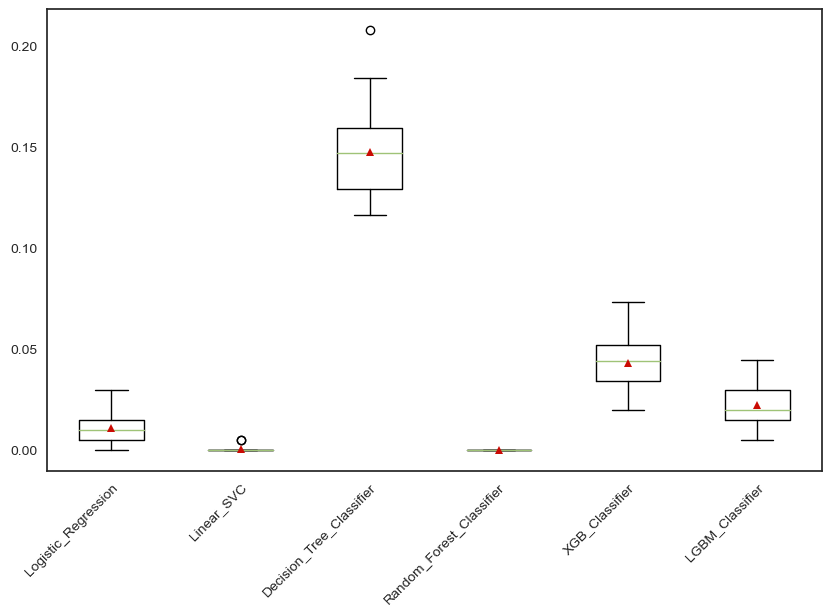

In [52]:
# Tracé des résultats
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
# Boîte à moustaches des scores F2 pour chaque modèle
plt.boxplot(results, labels=names, showmeans=True)
# Personnalisation des étiquettes d'axe X
plt.xticks(fontsize=10, rotation=45, ha='right', rotation_mode='anchor')
# Affichage du graphique
plt.show()

Les résultats sont très décevants quelque soit le modèle utilisé !

En plus de supposer que la distribution des classes est équilibrée, la plupart des algorithmes d'apprentissage automatique supposent également que les erreurs de prédiction commises par un classificateur sont les mêmes, ce que l'on appelle *miss-classifications*. Ce n'est généralement pas le cas pour les problèmes de classification binaire, en particulier ceux qui ont une distribution de classe déséquilibrée.

## Prise en compte du déséquilibre des classes : *Cost-Sensitive Learning*

In [53]:
# Définition des modèles à tester
def get_models_2():
    models, names = list(), list()
    # Régression Logistique
    models.append(LogisticRegression(class_weight='balanced'))
    names.append('Logistic_Regression_weight')
    # Support Vector Machine linéaire
    models.append(LinearSVC(class_weight='balanced'))
    names.append('Linear_SVC_weight')
    # Arbre de Décision
    models.append(DecisionTreeClassifier(class_weight='balanced'))
    names.append('Decision_Tree_Classifier_weight')
    # Random Forest
    models.append(RandomForestClassifier(class_weight="balanced"))
    names.append('Random_Forest_Classifier_weight')
    # XGBoost
    models.append(XGBClassifier(scale_pos_weight=99))
    names.append('XGB_Classifier_weight') 
    # LightGBM
    models.append(LGBMClassifier(class_weight="balanced"))
    names.append('LGBM_Classifier_weight')
    return models, names

In [54]:
# Définition des modèles
models, names = get_models_2()
results = list()

# Évaluation de chaque modèle
for i in range(len(models)):
    temps = time.time()
    
    # Envelopper le modèle dans un pipeline
    pipeline = Pipeline(steps=[('m', models[i])])
    scores = evaluate_model(X_train_sd, y_train, pipeline)
    results.append(scores)
    duration=time.time()-temps
    
    # Résumé et stockage des résultats
    print(f"Score F2 du modèle {names[i]} : moyenne = {np.mean(scores):.2%}, écart_type = {np.std(scores):.2%}")
    print(f"Temps de Calcul pour {names[i]} : {duration:>15.2f} secondes")
    print(end='\n\n')

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

Score F2 du modèle Logistic_Regression_weight : moyenne = 39.57%, écart_type = 1.61%
Temps de Calcul pour Logistic_Regression_weight :            8.00 secondes




/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to s

Score F2 du modèle Linear_SVC_weight : moyenne = 39.03%, écart_type = 1.62%
Temps de Calcul pour Linear_SVC_weight :          167.07 secondes


Score F2 du modèle Decision_Tree_Classifier_weight : moyenne = 12.96%, écart_type = 2.08%
Temps de Calcul pour Decision_Tree_Classifier_weight :           10.72 secondes




/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

Score F2 du modèle Random_Forest_Classifier_weight : moyenne = 0.00%, écart_type = 0.00%
Temps de Calcul pour Random_Forest_Classifier_weight :          100.24 secondes


Score F2 du modèle XGB_Classifier_weight : moyenne = 32.49%, écart_type = 2.17%
Temps de Calcul pour XGB_Classifier_weight :           16.17 secondes




/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

Score F2 du modèle LGBM_Classifier_weight : moyenne = 37.61%, écart_type = 1.72%
Temps de Calcul pour LGBM_Classifier_weight :           13.01 secondes




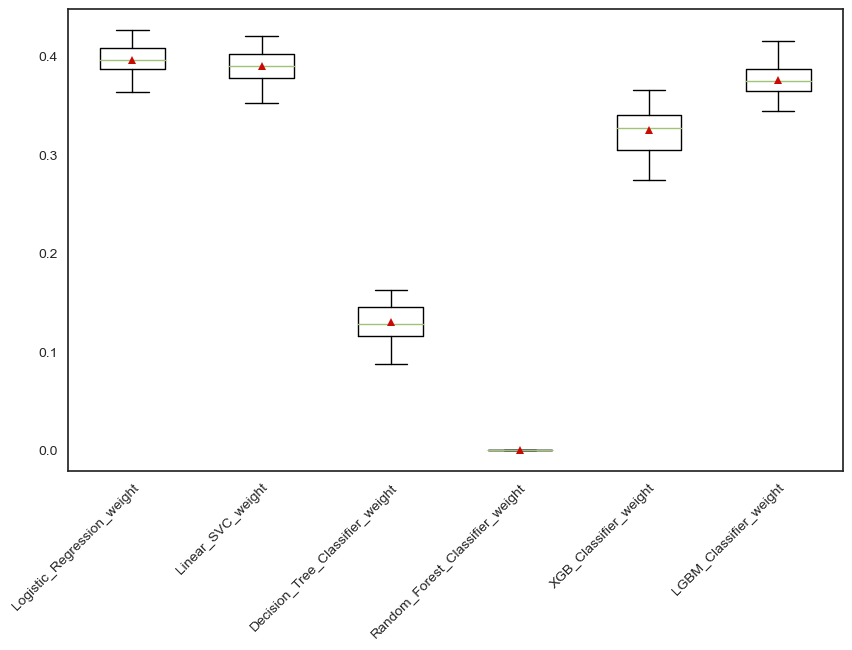

In [55]:
# plot des résultats
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))
# Boîte à moustaches des scores F2 pour chaque modèle
plt.boxplot(results, labels=names, showmeans=True)
# Personnalisation des étiquettes d'axe X
plt.xticks(fontsize=10, rotation=45, ha='right', rotation_mode='anchor')
# Affichage du graphique
plt.show()

Nous pouvons voir que 3 des modèles testés ont une mesure F2 supérieure à la valeur par défaut de prédire la classe majoritaire dans tous les cas (30.5%).
Les 3 meilleurs scores F2 sont obtenus avec les modèles light GBM (37.6%) puis la régression logistique (39.5%) et LinearSVC (39.0%).

L'utilisation d'une pondération de classe qui est le rapport inverse des données d'apprentissage n'est qu'une heuristique. Il est possible que de meilleures performances puissent être obtenues avec une pondération de classe différente, et cela aussi dépendra du choix de la mesure de performance utilisée pour évaluer le modèle. Dans cette section, nous rechercherons à l'aide d'une grille une gamme de pondérations de classe différentes pour les 2 premiers modèles que nous avons sélectionnés (Le SVM nécessitant un temps de calcul trop important) et découvrirons celui qui se traduit par le meilleur score F2.

### La régression logistique pondérée

In [56]:
# Importation de la classe GridSearchCV pour la recherche des meilleurs hyperparamètres
from sklearn.model_selection import GridSearchCV

In [57]:
# Définition du modèle
model = LogisticRegression()

# Recherche des meilleurs paramètres avec GridSearch
param_grid = [{'class_weight': ['balanced', {0: 100, 1: 1}, {0: 10, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 10}, {0: 1, 1: 100}]}]


# Définition de la procédure d'évaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=101)

# Définition de la recherche par grille
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    n_jobs=-2,
                    cv=cv,
                    scoring=make_scorer(fbeta_score, beta=2)) 

# Exécution de la recherche par grille
grid_result = grid.fit(X_train_sd, y_train)

# Rapport de la meilleure configuration
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

# Rapport de toutes les configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

Best: 0.395686 using {'class_weight': 'balanced'}
0.395686 (0.016076) with: {'class_weight': 'balanced'}
0.000000 (0.000000) with: {'class_weight': {0: 100, 1: 1}}
0.000000 (0.000000) with: {'class_weight': {0: 10, 1: 1}}
0.011146 (0.007350) with: {'class_weight': {0: 1, 1: 1}}
0.395462 (0.018156) with: {'class_weight': {0: 1, 1: 10}}
0.306527 (0.001250) with: {'class_weight': {0: 1, 1: 100}}


### Light Gradient Boosted Machine (LightGBM) Ensemble

In [58]:
# Définition du modèle
model = LGBMClassifier()

# Recherche des meilleurs paramètres avec GridSearch
param_grid = [{'class_weight': ['balanced', {0: 100, 1: 1}, {0: 10, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 10}, {0: 1, 1: 100}]}]


# Définition de la procédure d'évaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=101)

# Définition de la recherche par grille
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    n_jobs=-2,
                    cv=cv,
                    scoring=make_scorer(fbeta_score, beta=2)) 

# Exécution de la recherche par grille
grid_result = grid.fit(X_train_sd, y_train)

# Rapport de la meilleure configuration
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

# Rapport de toutes les configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

Best: 0.376140 using {'class_weight': 'balanced'}
0.376140 (0.017162) with: {'class_weight': 'balanced'}
0.001838 (0.003031) with: {'class_weight': {0: 100, 1: 1}}
0.005670 (0.004600) with: {'class_weight': {0: 10, 1: 1}}
0.022195 (0.009871) with: {'class_weight': {0: 1, 1: 1}}
0.363597 (0.025103) with: {'class_weight': {0: 1, 1: 10}}
0.361013 (0.009414) with: {'class_weight': {0: 1, 1: 100}}


## Prise en compte du déséquilibre des classes : Oversampling Methods

In [59]:
# Importation des modules nécessaires

from sklearn.metrics import make_scorer
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE
)

from imblearn.pipeline import Pipeline

In [60]:
# Évaluer un modèle

def evaluate_model(X, y, model):
    # Définir la procédure d'évaluation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=101)
    # Définir la métrique d'évaluation du modèle
    metric = make_scorer(fbeta_score, beta=2)
   # Évaluer le modèle
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-2)
    return scores

In [61]:
# Définir les modèles de suréchantillonnage à tester

def get_models():
    models, names = list(), list()
    
    # RandomOverSampler
    models.append(RandomOverSampler(sampling_strategy='auto',  
                                    random_state=101))
    names.append('Random_Over_Sampler')
    
    # SMOTE
    models.append(SMOTE(sampling_strategy='auto',  # échantillonne uniquement la classe minoritaire
                        random_state=101,   # pour la reproductibilité
                        k_neighbors=5,
                        n_jobs=-2))
    names.append('SMOTE')
    
    # ADASYN
    models.append(ADASYN(sampling_strategy='auto',   # échantillonne uniquement la classe minoritaire
                        random_state=101,  # pour la reproductibilité
                        n_neighbors=5,
                        n_jobs=-2))
    names.append('ADASYN')
    
    # BorderlineSMOTE1
    models.append(BorderlineSMOTE(sampling_strategy='auto',  # échantillonne uniquement la classe minoritaire
                                  random_state=101,  # pour la reproductibilité
                                  k_neighbors=5,
                                  m_neighbors=10,
                                  kind='borderline-1',
                                  n_jobs=-2))
    names.append('Borderline_SMOTE_1')
    
   # BorderlineSMOTE2
    models.append(BorderlineSMOTE(sampling_strategy='auto',  # échantillonne uniquement la classe minoritaire
                                  random_state=101,  # pour la reproductibilité
                                  k_neighbors=5,
                                  m_neighbors=10,
                                  kind='borderline-2',
                                  n_jobs=-2))
    names.append('Borderline_SMOTE_2')

    return models, names

In [62]:
# Définir les modèles
models, names = get_models()
results = list()

# Évaluer chaque modèle
for i in range(len(models)):
    temps = time.time()
    # Définir le modèle
    model = LGBMClassifier()
    # Définir les étapes du pipeline
    steps = [('s', StandardScaler()), ('o', models[i]), ('m', model)]
    # Définir le pipeline
    pipeline = Pipeline(steps=steps)
   # Évaluer le modèle et stocker les résultats
    scores = evaluate_model(X_Xtrain, y_train, pipeline) # Données AVANT STANDARDISATION
    results.append(scores)
    duration=time.time()-temps
    # Résumer et stocker
    print(f"Score F2 du modèle {names[i]} : moyenne = {np.mean(scores):.2%}, écart_type = {np.std(scores):.2%}")
    print(f"Temps de Calcul pour {names[i]} : {duration:>15.2f} secondes")
    print(end='\n\n')

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

Score F2 du modèle Random_Over_Sampler : moyenne = 36.95%, écart_type = 1.93%
Temps de Calcul pour Random_Over_Sampler :           31.59 secondes




/Users/admin/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y w

Score F2 du modèle SMOTE : moyenne = 1.96%, écart_type = 0.86%
Temps de Calcul pour SMOTE :           36.99 secondes




/Users/admin/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed wh

Score F2 du modèle ADASYN : moyenne = 1.99%, écart_type = 0.72%
Temps de Calcul pour ADASYN :           42.15 secondes




/Users/admin/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vect

Score F2 du modèle Borderline_SMOTE_1 : moyenne = 2.15%, écart_type = 0.84%
Temps de Calcul pour Borderline_SMOTE_1 :           42.17 secondes




/Users/admin/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/filter.py:192: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vect

Score F2 du modèle Borderline_SMOTE_2 : moyenne = 1.89%, écart_type = 0.69%
Temps de Calcul pour Borderline_SMOTE_2 :           42.85 secondes




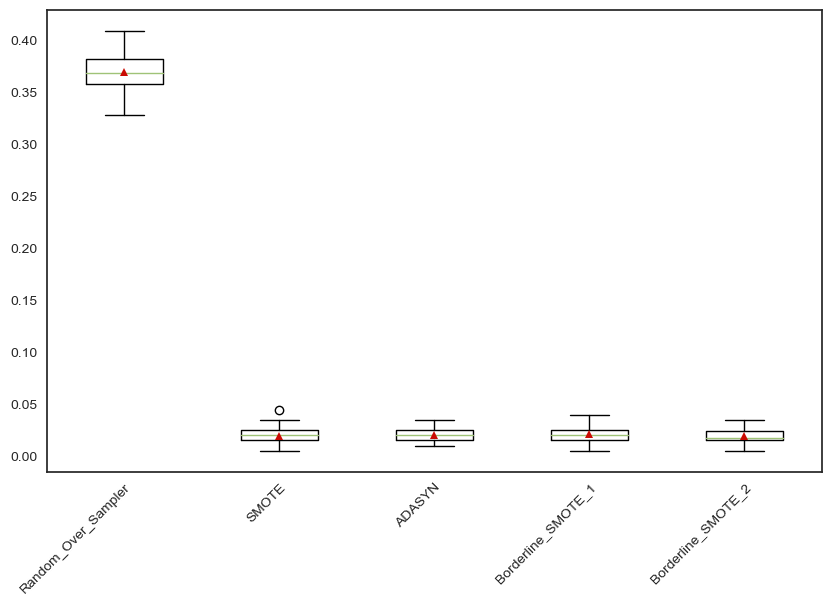

In [63]:
# plot les résultats
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))

plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(fontsize=10, rotation=45, ha='right', rotation_mode='anchor')
plt.show()

La technique de l'Oversampling n'améliore pas les résultats de celle du "Cost-Sensitive Learning" pour le modèle de prédiction LightGBM.

## Optimisation du modèle sélectionné : LightGBM

### Exploration du nombre d'arbres

Un hyperparamètre important pour l'algorithme d'ensemble LightGBM est le nombre d'arbres de décision utilisés dans l'ensemble.

Rappelez-vous que les arbres de décision sont ajoutés au modèle de manière séquentielle dans le but de corriger et d'améliorer les prédictions faites par les arbres précédents. En tant que tel, plus d'arbres sont souvent meilleurs.

Le nombre d'arbres peut être défini via l'argument " n_estimators " et sa valeur par défaut est 100.

In [64]:
# Obtenir une liste de modèles à évaluer
def get_models():
    models = dict()
    trees = [10, 50, 100, 200, 300, 400, 500, 1000]
    for n in trees:
        models[str(n)] = LGBMClassifier(n_estimators=n, class_weight="balanced")
    return models
 
# Évaluer un modèle donné en utilisant la validation croisée
def evaluate_model(model):
    # Utilisation de la validation croisée répétée avec 10 plis répétés 3 fois
    cv = RepeatedStratifiedKFold(n_splits=10,   #  Il divise l'ensemble de données en 10 plis (folds) pour l'évaluation croisée.
                                 n_repeats=3,   # Il répète le processus de validation croisée complet 3 fois.
                                 random_state=101  # Il fixe la graine aléatoire (random seed) à 101, assurant ainsi la reproductibilité des résultats.
                                )
    # Calcul des scores de performance en utilisant la validation croisée
    scores = cross_val_score(model, X_train_sd, y_train, 
                             scoring="roc_auc", # pour évaluer le modèle en utilisant la métrique ROC-AUC (aire sous la courbe ROC) 
                             # à l'aide de la validation croisée.
                             cv=cv, n_jobs=-2) #  indique que l'évaluation peut être parallélisée sur tous les cœurs disponibles, 
    # sauf un, pour accélérer le processus.
    # Retourne les scores obtenus
    return scores
 
# Obtenir les modèles à évaluer
models = get_models()

# Évaluer les modèles et stocker les résultats
temps = time.time()

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
     # Résumer et stocker
    print('> %s arbres : %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

duration=time.time()-temps
print(f"Temps d'exécution des calculs : {duration:>.2f} secondes")

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

> 10 arbres : 0.701 (0.017)


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed w

> 50 arbres : 0.725 (0.015)


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

> 100 arbres : 0.721 (0.014)


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

> 200 arbres : 0.709 (0.016)


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed w

> 300 arbres : 0.699 (0.017)


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

> 400 arbres : 0.691 (0.017)


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

> 500 arbres : 0.685 (0.017)


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

> 1000 arbres : 0.673 (0.017)
Temps d'exécution des calculs : 231.31 secondes


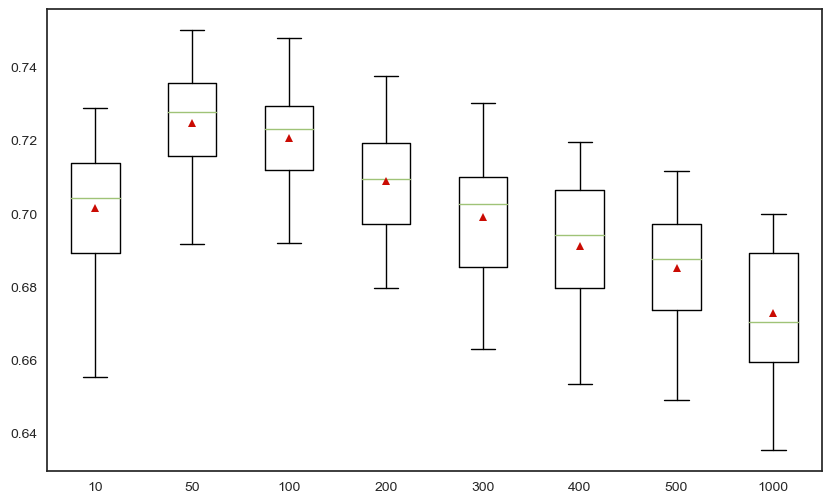

In [65]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))

#  Plot les performances des modèles pour la comparaison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Ce graphique rapporte le roc-auc (aire sous la courbe ROC) moyen pour chaque nombre d'arbres de décision configuré.
Dans ce cas, nous pouvons voir que les performances s'améliorent sur cet ensemble de données jusqu'à environ 100 arbres, après quoi les performances semblent se stabiliser puis décroître.

## Exploration de la profondeur des arbres

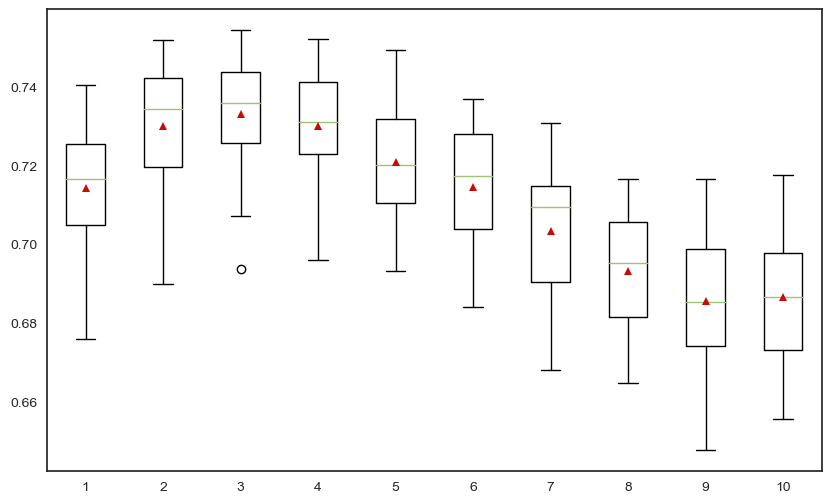

In [67]:
# Définir le style des axes du graphique
sns.set_style("ticks")
# Créer une figure avec une taille de 10x6
fig, ax = plt.subplots(figsize=(10, 6))

# Plot les performances des modèles pour la comparaison sous forme de boîte
plt.boxplot(results, labels=names, showmeans=True)
# Afficher le graphique
plt.show()

Nous pouvons voir l'augmentation des performances du modèle avec la profondeur de l'arbre jusqu'à une profondeur de cinq niveaux, après quoi les performances décroissent.

## Exploration du taux d'apprentissage

Le taux d'apprentissage contrôle la quantité de contribution que chaque modèle a sur la prédiction d'ensemble.

Des taux plus faibles peuvent nécessiter plus d'arbres de décision dans l'ensemble.

Le taux d'apprentissage peut être contrôlé via l'argument « learning_rate » et sa valeur par défaut est 0,1.

L' exemple ci-dessous explore le taux d'apprentissage et compare l'effet des valeurs comprises entre 0,0001 et 1,0.

In [68]:
# Obtenir une liste de modèles à évaluer
def get_models():
    models = dict()
    rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = LGBMClassifier(learning_rate=r,
                                     max_depth=5, num_leaves=2**5,
                                     n_estimators=100, class_weight="balanced")
    return models
 
# Évaluer un modèle donné en utilisant la validation croisée
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=101)
    scores = cross_val_score(model, X_train_sd, y_train, 
                             scoring="roc_auc", 
                             cv=cv, n_jobs=-2)
    return scores
 
# Obtenir les modèles à évaluer
models = get_models()

# Évaluer les modèles et stocker les résultats
temps = time.time()

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    
    # Résumer et stocker les résultats
    print("> Taux d'apprentissage %s : %.3f (%.3f)" % (name, np.mean(scores), np.std(scores)))

duration=time.time()-temps
print(f"Temps d'exécution des calculs : {duration:>.2f} secondes")

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed w

> Taux d'apprentissage 0.0001 : 0.664 (0.023)


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

> Taux d'apprentissage 0.0010 : 0.676 (0.021)


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

> Taux d'apprentissage 0.0100 : 0.702 (0.018)


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

> Taux d'apprentissage 0.1000 : 0.721 (0.015)


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

> Taux d'apprentissage 1.0000 : 0.634 (0.019)
Temps d'exécution des calculs : 68.84 secondes


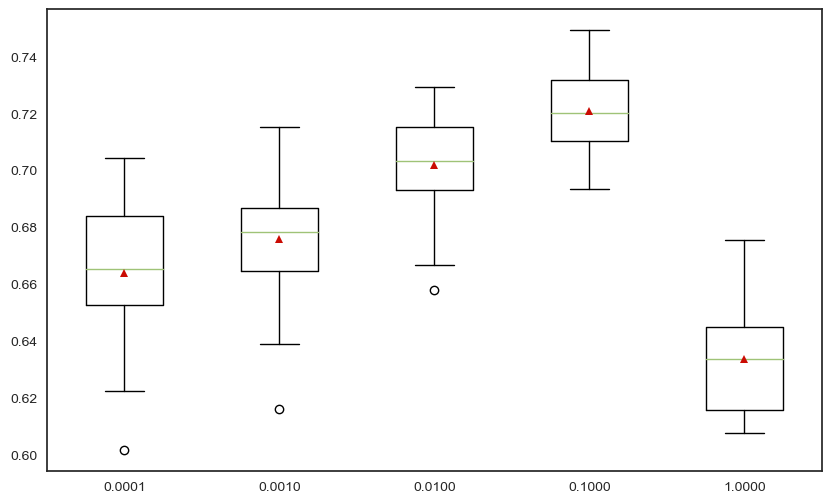

In [69]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer la performance des modèles pour la comparaison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Exploration du type de boost

In [70]:
# Obtenir une liste de modèles à évaluer
def get_models():
    models = dict()
    types = ['gbdt', 'dart', 'goss']
    for t in types:
        models[t] = LGBMClassifier(boosting_type=t,
                                   learning_rate=0.1,
                                   max_depth=5, num_leaves=2**5,
                                   n_estimators=100, class_weight="balanced")
    return models
 
# Évaluer un modèle donné en utilisant la validation croisée
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=101)
    scores = cross_val_score(model, X_train_sd, y_train, 
                             scoring="roc_auc", 
                             cv=cv, n_jobs=-2)
    return scores
 
# Obtenir les modèles à évaluer
models = get_models()

# Évaluer les modèles et stocker les résultats
temps = time.time()

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    
    # Résumer et stocker
    print("> Type de boosting %s : %.3f (%.3f)" % (name, np.mean(scores), np.std(scores)))

duration=time.time()-temps
print(f"Temps d'exécution des calculs : {duration:>.2f} secondes")

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

> Type de boosting gbdt : 0.721 (0.015)


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed 

> Type de boosting dart : 0.721 (0.016)


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed w

> Type de boosting goss : 0.728 (0.015)
Temps d'exécution des calculs : 54.79 secondes


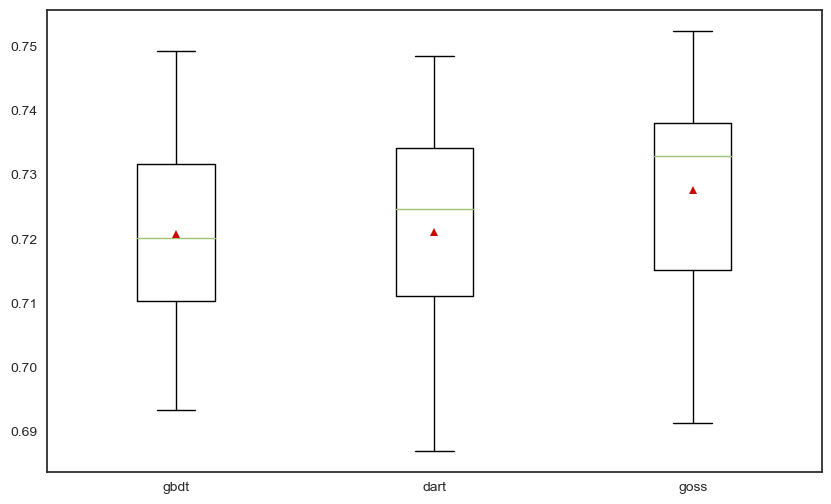

In [71]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(10, 6))

# Plot les performances des modèles pour la comparaison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Exploration des autres paramètres

In [72]:
# Définir le modèle LGBMClassifier avec des paramètres spécifiques
model_LGBM = LGBMClassifier(boosting_type='gbdt',
                            learning_rate=0.1,
                            max_depth=5, num_leaves=2**5,
                            n_estimators=100, 
                            objective='binary',
                            class_weight="balanced",
                            random_state=101,
                            n_jobs=-2,)
# Entraîner le modèle sur les données d'entraînement
model_LGBM.fit(X_train_sd, y_train)

LGBMClassifier(class_weight='balanced', max_depth=5, n_jobs=-2, num_leaves=32,
               objective='binary', random_state=101)

In [73]:
from pprint import pprint
# Afficher les paramètres du modèle LightGBM Classifier
print('Paramètres LightGMB Classifier :\n')
pprint(model_LGBM.get_params())

Paramètres LightGMB Classifier :

{'boosting_type': 'gbdt',
 'class_weight': 'balanced',
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -2,
 'num_leaves': 32,
 'objective': 'binary',
 'random_state': 101,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}


In [74]:
# Importer le module du temps
import time
# Enregistrer le temps au début de l'exécution
temps1=time.time()

# Définir l'espace de recherche des hyperparamètres
param_grid = { 
    # Pourcentage de colonnes à échantillonner de manière aléatoire pour chaque arbre.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
   # reg_alpha fournit une régularisation l1 aux poids, des valeurs plus élevées donnent des modèles plus conservateurs
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda fournit une régularisation l2 aux poids, des valeurs plus élevées donnent des modèles plus conservateurs
    "reg_lambda": [0, 0.5, 1, 5]
    }

# Mettre en place la validation croisée k-fold
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=101)

# Définir la recherche sur grille
grid_search = GridSearchCV(estimator=model_LGBM, 
                           param_grid=param_grid, 
                           n_jobs=-2, 
                           cv=kfold, 
                           scoring="roc_auc",
                           verbose=0)
# Effectuer la recherche sur grille
grid_result = grid_search.fit(X_train_sd, y_train)

# Afficher le meilleur score et les hyperparamètres correspondants
print(f'The best score is {grid_result.best_score_:.4f}')
print('The best score standard deviation is', round(grid_result.cv_results_['std_test_score'][grid_result.best_index_], 4))
print(f'The best hyperparameters are {grid_result.best_params_}')
# Enregistrer la durée de la recherche des hyperparamètres
duration1=time.time()-temps1
print("temps de la recherche des hyper-paramètres : ", "%15.2f" % duration1, "secondes")

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed w

The best score is 0.7329
The best score standard deviation is 0.0148
The best hyperparameters are {'colsample_bytree': 0.5, 'reg_alpha': 5, 'reg_lambda': 0.5}
temps de la recherche des hyper-paramètres :           743.86 secondes


## Analyse de la performance du modèle

In [75]:
# Importation des bibliothèques nécessaires
import lightgbm  # Importation de la bibliothèque LightGBM
from lightgbm import LGBMClassifier  # Importation de la classe LGBMClassifier de LightGBM


from sklearn.metrics import (classification_report, # Importation des fonctions de métriques de classification
                             precision_score,
                             recall_score,
                             f1_score,
                             precision_recall_fscore_support,
                             fbeta_score, 
                             make_scorer)
# Importation des classes de visualisation de Yellowbrick
from yellowbrick.classifier import ClassificationReport, DiscriminationThreshold


In [76]:
# Définition du modèle LGBMClassifier avec des hyperparamètres spécifiques
model_LGBM = LGBMClassifier(boosting_type='gbdt', # Type de boosting utilisé (gbdt : Gradient Boosting Decision Tree)
                            learning_rate=0.1,  # Taux d'apprentissage
                            max_depth=5,  # Profondeur maximale des arbres
                            num_leaves=2**5,  # Nombre de feuilles par arbre
                            n_estimators=100,  # Nombre d'estimateurs (arbres) dans le modèle
                            objective='binary',  # Objectif de la classification binaire
                            class_weight="balanced",  # Poids équilibrés pour les classes
                            colsample_bytree=0.3, # Fraction de fonctionnalités à utiliser par arbre
                            reg_alpha=5,  # Terme de régularisation L1
                            reg_lambda=1,       # Terme de régularisation L2                     
                            random_state=101, # Graine aléatoire pour la reproductibilité
                            n_jobs=-2,)  # Nombre de cœurs de processeur à utiliser (-2 pour utiliser tous les cœurs sauf un)

# Entraînement du modèle sur les données d'entraînement standardisées
model_LGBM_fit = model_LGBM.fit(X_train_sd, y_train)

# Prédictions sur les données de validation
y_pred_lgbm = model_LGBM_fit.predict(X_valid_sd)
# Probabilités prédites sur les données de validation
y_pred_lgbm_proba = model_LGBM_fit.predict_proba(X_valid_sd)

In [77]:
# Affichage du rapport de classification pour évaluer les performances du modèle
print(classification_report(y_valid, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.95      0.76      0.85     12152
           1       0.18      0.57      0.27      1067

    accuracy                           0.75     13219
   macro avg       0.56      0.67      0.56     13219
weighted avg       0.89      0.75      0.80     13219



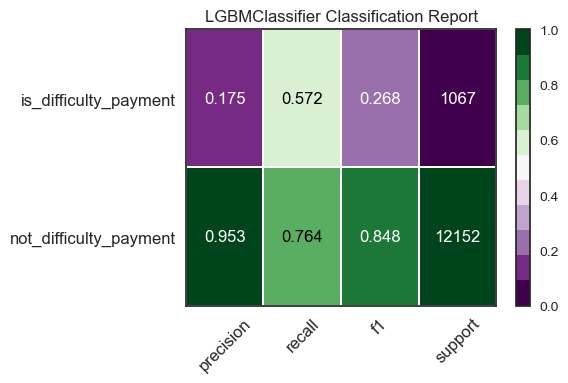

<Axes: title={'center': 'LGBMClassifier Classification Report'}>

In [78]:
# Identification des classes. La variable classes sera utile lors de l'utilisation des visualiseurs de Yellowbrick
classes = ['not_difficulty_payment', 'is_difficulty_payment']
# Configuration du style seaborn
sns.set_style("ticks")
# Création d'une figure avec une taille spécifiée
fig, ax = plt.subplots(figsize=(6, 4))
# Création d'une instance de la classe ClassificationReport de Yellowbrick
visualizer = ClassificationReport(model_LGBM_fit, classes=classes, support=True, cmap='PRGn')
# Entraînement du visualiseur sur les données d'entraînement
visualizer.fit(X_train_sd, y_train)  
# Évaluation du modèle sur les données de validation
visualizer.score(X_valid_sd, y_valid)    
# Affichage du visualiseur avec le rapport de classification
visualizer.show()                       

In [79]:
# Calculer et afficher le score d'exactitude sur les ensembles d'entraînement et de test
print(f"Train Accuracy : {accuracy_score(y_train, model_LGBM_fit.predict(X_train_sd)):.2%}")
print(f"Test Accuracy : {accuracy_score(y_valid, y_pred_lgbm):.2%}")

Train Accuracy : 77.64%
Test Accuracy : 74.84%


In [80]:
# Calculer et afficher le score de précision sur les ensembles d'entraînement et de test
print(f"Train Precision : {precision_score(y_train, model_LGBM_fit.predict(X_train_sd)):.2%}")
print(f"Test Precision : {precision_score(y_valid, y_pred_lgbm):.2%}")

Train Precision : 23.54%
Test Precision : 17.53%


In [81]:
# Calculer et afficher le score de rappel (recall) sur les ensembles d'entraînement et de test
print(f"Train Recall : {recall_score(y_train, model_LGBM_fit.predict(X_train_sd)):.2%}")
print(f"Test Recall : {recall_score(y_valid, y_pred_lgbm):.2%}")

Train Recall : 78.79%
Test Recall : 57.17%


In [82]:
# Calculer et afficher le score F1 sur les ensembles d'entraînement et de test
print(f"Train f1_score : {f1_score(y_train, model_LGBM_fit.predict(X_train_sd)):.2%}")
print(f"Test f1_score : {f1_score(y_valid, y_pred_lgbm):.2%}")

Train f1_score : 36.25%
Test f1_score : 26.84%


In [83]:
# Calculer et afficher le score F2 sur les ensembles d'entraînement et de test
print(f"Train f2_score : {fbeta_score(y_train, model_LGBM_fit.predict(X_train_sd), beta=2):.2%}")
print(f"Test f2_score : {fbeta_score(y_valid, y_pred_lgbm, beta=2):.2%}")

Train f2_score : 53.62%
Test f2_score : 39.37%


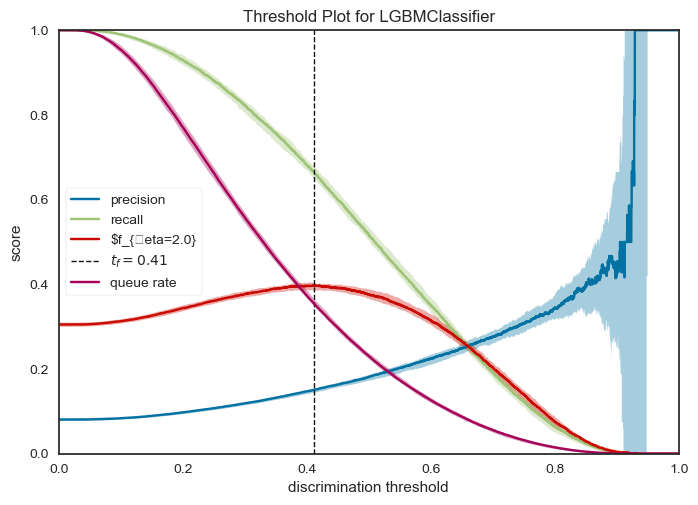

<Axes: title={'center': 'Threshold Plot for LGBMClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [84]:
# Créer une instance du visualiseur DiscriminationThreshold avec des paramètres spécifiques
visualizer = DiscriminationThreshold(model_LGBM,
                                     n_trials=50,
                                     cv=0.5,
                                     fbeta = 2.0,
                                     argmax='fscore',
                                     random_state=101,
                                     is_fitted='auto')
# Entraîner le visualiseur sur les données d'entraînement
visualizer.fit(X_train_sd, y_train)  
# Évaluer le modèle sur les données de validation
visualizer.score(X_valid_sd, y_valid)  
# Afficher le graphique illustrant l'impact du seuil de discrimination sur les performances
visualizer.show()  

Dans la figure ci-dessus, nous voyons le visualiseur réglé pour rechercher le F2 score optimal, qui est annoté comme un seuil de 0,48. Le modèle est exécuté plusieurs fois sur plusieurs divisions train/test afin de tenir compte de sa variabilité par rapport aux métriques (représentées par la zone de remplissage autour de la courbe médiane).

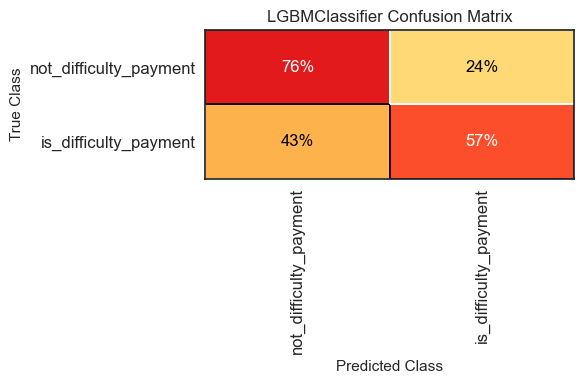

<Axes: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [85]:
# Utiliser Yellowbrick pour visualiser la matrice de confusion du modèle LightGBM
from yellowbrick.classifier import ConfusionMatrix
# Définir le style du graphique
sns.set_style("ticks")
# Créer une figure et des axes
fig, ax = plt.subplots(figsize=(6, 4))
# Initialiser la matrice de confusion avec le modèle LightGBM préalablement ajusté
cm = ConfusionMatrix(model_LGBM_fit, classes=classes, percent=True)
# Entraîner la matrice de confusion sur les données d'entraînement
cm.fit(X_train_sd, y_train)    
# Évaluer le modèle sur les données de validation
cm.score(X_valid_sd, y_valid)  
# Afficher la matrice de confusion
cm.show()

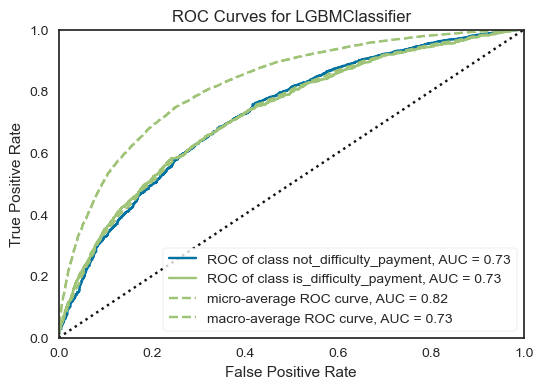

<Axes: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [86]:
# Utiliser Yellowbrick pour visualiser la courbe ROC-AUC du modèle LightGBM
from yellowbrick.classifier import ROCAUC
# Définir le style du graphique
sns.set_style("ticks")
# Créer une figure et des axes
fig, ax = plt.subplots(figsize=(6, 4))
# Initialiser le visualizer ROC-AUC avec le modèle LightGBM préalablement ajusté
vis_rocauc = ROCAUC(model_LGBM_fit, classes=classes, random_state=101)
# Entraîner le visualizer sur les données d'entraînement
vis_rocauc.fit(X_train_sd, y_train) 
# Évaluer le modèle sur les données de validation
vis_rocauc.score(X_valid_sd, y_valid)
# Afficher la courbe ROC-AUC
vis_rocauc.show()                       

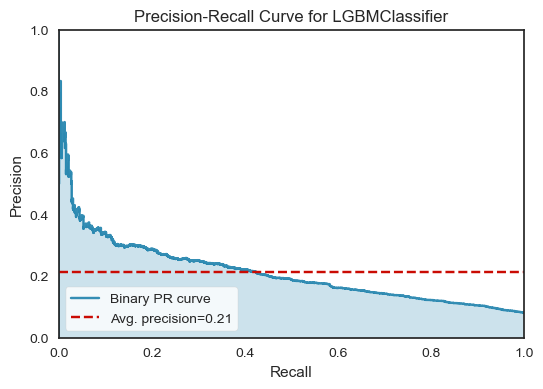

<Axes: title={'center': 'Precision-Recall Curve for LGBMClassifier'}, xlabel='Recall', ylabel='Precision'>

In [87]:
# Utiliser Yellowbrick pour visualiser la courbe Précision-Rappel (Precision-Recall Curve) du modèle LightGBM
from yellowbrick.classifier import PrecisionRecallCurve
# Définir le style du graphique
sns.set_style("ticks")
# Créer une figure et des axes
fig, ax = plt.subplots(figsize=(6, 4))
# Initialiser le visualizer Precision-Recall Curve avec le modèle LightGBM préalablement ajusté
vis_prc = PrecisionRecallCurve(model_LGBM_fit, random_state=101)
# Entraîner le visualizer sur les données d'entraînement
vis_prc.fit(X_train_sd, y_train) 
# Évaluer le modèle sur les données de validation
vis_prc.score(X_valid_sd, y_valid)  
# Afficher la courbe Precision-Recall
vis_prc.show()  